# Exploratory Analysis

#### Nick Kalenichenko (nhk6up@virginia.edu) DS 5001 Spring 2023

# Import files

In [1]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [2]:
import HarryPotterETA as hpe
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
import plotly_express as px
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import word2vec
from gensim import corpora, models
from sklearn.manifold import TSNE
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
import pprint


import warnings
warnings.filterwarnings('ignore')

In [3]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']

In [4]:
LINES_1 = hpe.importFiles("data/Book1.txt")
LINES_2 = hpe.importFiles("data/Book2.txt")
LINES_3 = hpe.importFiles("data/Book3.txt")
LINES_4 = hpe.importFiles("data/Book4.txt")
LINES_5 = hpe.importFiles("data/Book5.txt")
LINES_6 = hpe.importFiles("data/Book6.txt")
LINES_7 = hpe.importFiles("data/Book7.txt")

In [5]:
title_1 = 'The Philosopher\'s Stone'
title_2 = 'The Chamber of Secrets'
title_3 = 'The Prisoner of Azkaban'
title_4 = 'The Goblet of Fire'
title_5 = 'The Order of the Phoenix'
title_6 = 'The Half Blood Prince'
title_7 = 'The Deathly Hallows'

In [6]:
# Get rid of 'Page | 5' in all books

LINES_1 = LINES_1.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[5:]
LINES_2 = LINES_2.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[15:]
LINES_3 = LINES_3.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[5:]
LINES_4 = LINES_4.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[5:]
LINES_4 = LINES_4.replace(to_replace ='^\s*(?:Harry Potter and the Goblet of Fire)\s+(.*)', value = '', regex = True).loc[5:]
LINES_5 = LINES_5.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[11:]
LINES_6 = LINES_6.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[10:]
LINES_7 = LINES_7.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[6:]

# Chunk by Chapter

In [7]:
chaps1_titles, chaps1 = hpe.chunk_chaps(LINES_1, r"^\s*([A-Z\'\s]+|[A-Z\s]+)\s*$", 1, OHCO)
chaps2_titles, chaps2 = hpe.chunk_chaps(LINES_2, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 2, OHCO)
chaps3_titles, chaps3 = hpe.chunk_chaps(LINES_3, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 3, OHCO)
chaps4_titles, chaps4 = hpe.chunk_chaps(LINES_4, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 4, OHCO)
chaps5_titles, chaps5 = hpe.chunk_chaps(LINES_5, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 5, OHCO)
chaps6_titles, chaps6 = hpe.chunk_chaps(LINES_6, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 6, OHCO)
chaps7_titles, chaps7 = hpe.chunk_chaps(LINES_7, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 7, OHCO)

# Chunk by Paragraphs

In [8]:
# Set paragraph pattern
paras_pattern = r'\n\n+'
# Chunk by paragraphs
paras1 = hpe.chap_to_par(chaps1, paras_pattern, OHCO)
paras2 = hpe.chap_to_par(chaps2, paras_pattern, OHCO)
paras3 = hpe.chap_to_par(chaps3, paras_pattern, OHCO)
paras4 = hpe.chap_to_par(chaps4, paras_pattern, OHCO)
paras5 = hpe.chap_to_par(chaps5, paras_pattern, OHCO)
paras6 = hpe.chap_to_par(chaps6, paras_pattern, OHCO)
paras7 = hpe.chap_to_par(chaps7, paras_pattern, OHCO)

# Chunk by Sentences

In [9]:
sents_pattern = r'[.?!;:]+'
# Chunk by sentences
sents1 = hpe.par_to_sent(paras1, sents_pattern, OHCO)
sents2 = hpe.par_to_sent(paras2, sents_pattern, OHCO)
sents3 = hpe.par_to_sent(paras3, sents_pattern, OHCO)
sents4 = hpe.par_to_sent(paras4, sents_pattern, OHCO)
sents5 = hpe.par_to_sent(paras5, sents_pattern, OHCO)
sents6 = hpe.par_to_sent(paras6, sents_pattern, OHCO)
sents7 = hpe.par_to_sent(paras7, sents_pattern, OHCO)

In [10]:
# Average sentence length
(len(sents1) + len(sents2) + len(sents3) + len(sents4) + len(sents5) + len(sents6) + len(sents7))/7

15744.57142857143

# Chunk by Token

In [11]:
tokens_pattern = r"[\s',-]+"

tokens1 = hpe.sent_to_tok_pos(sents1, tokens_pattern, OHCO)
tokens2 = hpe.sent_to_tok_pos(sents2, tokens_pattern, OHCO)
tokens3 = hpe.sent_to_tok_pos(sents3, tokens_pattern, OHCO)
tokens4 = hpe.sent_to_tok_pos(sents4, tokens_pattern, OHCO)
tokens5 = hpe.sent_to_tok_pos(sents5, tokens_pattern, OHCO)
tokens6 = hpe.sent_to_tok_pos(sents6, tokens_pattern, OHCO)
tokens7 = hpe.sent_to_tok_pos(sents7, tokens_pattern, OHCO)

In [12]:
# Find average token length
(len(tokens1) + len(tokens2) + len(tokens3) + len(tokens4) + len(tokens5) + len(tokens6) + len(tokens7))/7

189055.14285714287

# Combine Books

In [13]:
tokens1['book_id'] = 1
tokens2['book_id'] = 2
tokens3['book_id'] = 3
tokens4['book_id'] = 4
tokens5['book_id'] = 5
tokens6['book_id'] = 6
tokens7['book_id'] = 7

# Combine all tokiens
TOKENS = pd.concat([tokens1, tokens2, tokens3, tokens4, tokens5, tokens6, tokens7]).dropna()
# Set index as book_id
TOKENS = TOKENS.set_index('book_id', append=True, inplace=False)
# Set OHCO
NEW_OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
CORPUS = TOKENS.reorder_levels(NEW_OHCO)

## Add Features to CORPUS

In [14]:
CORPUS['pos'] = CORPUS.pos_tuple.apply(lambda x: x[1])
CORPUS['token_str'] = CORPUS.pos_tuple.apply(lambda x: x[0])
CORPUS['term_str'] = CORPUS.token_str.str.lower()

In [15]:
CORPUS

pos_tuple  pos token_str   
book_id chap_num para_num sent_num token_num                                  
1       1.0      0        0        0               (Mr, NNP)  NNP        Mr  \
                                   1               (and, CC)   CC       and   
                                   2              (Mrs, NNP)  NNP       Mrs   
                                   3          (Dursley, NNP)  NNP   Dursley   
                                   4                  (,, ,)    ,         ,   
...                                                      ...  ...       ...   
7       37.0     78       0        7          (nineteen, JJ)   JJ  nineteen   
                                   8            (years, NNS)  NNS     years   
                          1        0               (All, DT)   DT       All   
                                   1              (was, VBD)  VBD       was   
                                   2              (well, RB)   RB      well   

                                              term_str  
book_id chap_num para_num sent_num token_num            
1       1.0      0        0        0                mr  
                                   1               and  
                                   2               mrs  
                                   3           dursley  
                                   4                 ,  
...                                                ...  
7       37.0     78       0        7          nineteen  
                                   8             years  
                          1        0               all  
                                   1               was  
                                   2              well  

[1323386 rows x 4 columns]

# Extract and Edit VOCAB

## Clean CORPUS

In [16]:
# POS to keep
POS_tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP',
            'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB',
            'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

CORPUS = CORPUS[CORPUS.pos.isin(POS_tags)]

In [17]:
# symbols still in corpus, found by looking at DTCM
symb_list = ['“', '”','’', '‘', '—', '%', '&', '\'', '\'s', '*', '-4', '|', '|486', '~', '•k', '■', '-□', '\\', '/', '/ine']

# Get rid of symbols
CORPUS = CORPUS[~CORPUS.term_str.isin(symb_list)]

## Get VOCAB Table from All Books

In [18]:
VOCAB = hpe.extract_vocab(CORPUS)
VOCAB

,n,p,i,n_chars
term_str,,,,
the,51842,4.635923e-02,4.431000,3
and,27639,2.471592e-02,5.338415,3
to,26855,2.401484e-02,5.379930,2
he,22174,1.982890e-02,5.656252,2
of,21813,1.950608e-02,5.679933,2
...,...,...,...,...
tunelessly,1,8.942408e-07,20.092833,10
ham-like,1,8.942408e-07,20.092833,8
diddydums,1,8.942408e-07,20.092833,9


In [19]:
# Add max_pos to vocab
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

In [20]:
# Add POS Ambiguity to vocab table
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

### Create POS_GROUP Table

In [21]:
tags_csv = [(line.split()[0], ' '.join(line.split()[1:])) 
            for line in open(f'data/upenn_tagset.txt', 'r').readlines()]

POS = pd.DataFrame(tags_csv)
POS.columns = ['pos_code','pos_def']
POS = POS.set_index('pos_code')
POS['n'] = CORPUS.pos.value_counts()
POS['n'] = POS['n'].fillna(0).astype('int')
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
POS['punc'] = POS.apply(lambda x: bool(re.match(r"^\W", x.name)), 1)

POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['pos_def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['pos_def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

POS_GROUP['n_terms'] = VOCAB.max_pos.value_counts() 
POS_GROUP['n_tokens'] = VOCAB.groupby('max_pos').n.sum()
POS_GROUP

,n,pos_def,p,i,h,n_terms,n_tokens
pos_group,,,,,,,
CC,35797,"conjunction, coordinating",3.201114e-02,4.965282,0.158944,6.0,35644.0
CD,5309,"numeral, cardinal",4.747525e-03,7.718609,0.036644,87.0,5516.0
DT,91895,determiner,8.217626e-02,3.605135,0.296256,17.0,91655.0
EX,2813,existential there,2.515499e-03,8.634939,0.021721,1.0,3835.0
FW,128,foreign word,1.144628e-04,13.092833,0.001499,12.0,51.0
IN,120095,"preposition or conjunction, subordinating",1.073939e-01,3.219017,0.345703,98.0,123882.0
JJ,66133,"adjective or numeral, ordinal; adjective, comp...",5.913883e-02,4.079751,0.241272,4123.0,67572.0
MD,11319,modal auxiliary,1.012191e-02,6.626374,0.067072,12.0,11311.0
NN,293769,"noun, common, singular or mass; noun, proper, ...",2.627002e-01,1.928511,0.506620,6261.0,141915.0


In [22]:
# Add stopwords to VOCAB table
stopwords = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
stopwords = stopwords.reset_index()
stopwords = stopwords.set_index('term_str')
stopwords.columns = ['dummy']
stopwords.dummy = 1

VOCAB['stop'] = VOCAB.index.map(stopwords.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [23]:
# Add stems

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

# Porter Stemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

# Snowball Stemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

# Lancaster Stemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)


# Add TFIDF and DFIDF

# Create LIB Table

In [110]:
lib_data = {'book_id': [1, 2, 3, 4, 5, 6, 7],
        'title': ['Harry Potter and the Philosopher\'s Stone',
            'Harry Potter and the Chamber of Secrets',
            'Harry Potter and the Prisoner of Azkaban',
            'Harry Potter and the Goblet of Fire',
            'Harry Potter and the Order of the Phoenix',
            'Harry Potter and the Half-Blood Prince',
            'Harry Potter and the Deathly Hallows'],
        'chapter_regex': ['^\s*([A-Z\'\s]+|[A-Z\s]+)\s*',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$']}

LIB = pd.DataFrame(lib_data).set_index('book_id')

In [111]:
LIB['book_len'] = CORPUS.groupby('book_id').term_str.count()
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_num']]\
    .drop_duplicates()\
    .groupby('book_id').chap_num.count()

In [26]:
VOCAB

,n,p,i,n_chars,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
the,51842,4.635923e-02,4.431000,3,DT,2,"{DT, NNP}",1,the,the,the
and,27639,2.471592e-02,5.338415,3,CC,2,"{CC, NNP}",1,and,and,and
to,26855,2.401484e-02,5.379930,2,TO,2,"{TO, NNP}",1,to,to,to
he,22174,1.982890e-02,5.656252,2,PRP,2,"{PRP, NNP}",1,he,he,he
of,21813,1.950608e-02,5.679933,2,IN,2,"{IN, NNP}",1,of,of,of
...,...,...,...,...,...,...,...,...,...,...,...
tunelessly,1,8.942408e-07,20.092833,10,RB,1,{RB},0,tunelessli,tuneless,tuneless
ham-like,1,8.942408e-07,20.092833,8,JJ,1,{JJ},0,ham-lik,ham-lik,ham-like
diddydums,1,8.942408e-07,20.092833,9,NNP,1,{NNP},0,diddydum,diddydum,diddydum


## Create BOW

In [27]:
bag=['book_id', 'chap_num']

BOW = hpe.create_bow(CORPUS, bag)
BOW

n
book_id chap_num term_str     
1       1.0      a         112
                 able        2
                 about      14
                 above       1
                 across      2
...                        ...
7       37.0     year        2
                 years       2
                 you        32
                 younger     3
                 your        3

[277080 rows x 1 columns]

## TFIDF and DFIDF

In [28]:
# Add dfidf and tfidf to VOCAB table

TFIDF, DFIDF = hpe.get_tfidf_dfidf(BOW)
VOCAB['dfidf'] = DFIDF
VOCAB['mean_tfidf'] = TFIDF.mean()

## Get Top 1000 Terms by DFIDF Without Proper Nouns

In [29]:
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split() # pos categories without proper nouns

VIDX = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]\
    .sort_values('dfidf', ascending=False)\
    .head(1000).index

VIDX

Index(['pressed', 'recognized', 'perfectly', 'hoping', 'touch', 'sideways',
       'definitely', 'information', 'send', 'join',
       ...
       'effect', 'thoroughly', 'shop', 'including', 'cracked', 'croaked',
       'crept', 'run', 'home', 'steps'],
      dtype='object', name='term_str', length=1000)

In [30]:
# Collapse TFIDF by book

MT = TFIDF[VIDX].groupby('book_id').mean().fillna(0) # MUST FILLNA

In [140]:
MT.shape

(7, 1000)

# Compute Various Distance Measures

In [31]:
# Normalize TFIDF using 3 methods

L0 = MT.astype('bool').astype('int') # Binary (Pseudo L)
L1 = MT.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = MT.apply(lambda x: x / norm(x), 1) # Euclidean

In [32]:
# Make Pairs

PAIRS = 1 - MT.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median
combos  = [
    (L2, 'euclidean', 'euclidean', euclidean_method),
    (MT,  'cosine', 'cosine', euclidean_method),
    (MT,  'cityblock', 'cityblock', general_method),
    (L0, 'jaccard', 'jaccard', general_method),
    (L1, 'jensenshannon', 'js', general_method),
]

for X, metric, label, _ in combos:
    PAIRS[label] = pdist(X, metric)

## Compare Correlations

In [112]:
corr_type = 'kendall'
CORR_MATRIX = MT.T.corr(corr_type)

LIB['kendall_sum'] = CORR_MATRIX.sum()

In [139]:
CORR_MATRIX.style.background_gradient(cmap='coolwarm')

book_id,1,2,3,4,5,6,7
book_id,,,,,,,
1,1.000000,0.209466,0.142343,0.114144,0.069146,0.005537,-0.027950
2,0.209466,1.000000,0.176609,0.109546,0.071958,-0.030763,-0.066422
3,0.142343,0.176609,1.000000,0.099792,0.073522,0.012533,-0.043966
4,0.114144,0.109546,0.099792,1.000000,0.129329,0.026931,-0.038104
5,0.069146,0.071958,0.073522,0.129329,1.000000,0.104032,-0.055005
6,0.005537,-0.030763,0.012533,0.026931,0.104032,1.000000,0.034809
7,-0.027950,-0.066422,-0.043966,-0.038104,-0.055005,0.034809,1.000000


# Create Time Token Matrix and plot Dispersion Plots

In [35]:
# Get all books

BOOK1 = hpe.get_book_from_corpus(CORPUS, 1)
BOOK2 = hpe.get_book_from_corpus(CORPUS, 2)
BOOK3 = hpe.get_book_from_corpus(CORPUS, 3)
BOOK4 = hpe.get_book_from_corpus(CORPUS, 4)
BOOK5 = hpe.get_book_from_corpus(CORPUS, 5)
BOOK6 = hpe.get_book_from_corpus(CORPUS, 6)
BOOK7 = hpe.get_book_from_corpus(CORPUS, 7)

In [36]:
# Compute TTM for book 1
TTM1 = hpe.get_TTM(BOOK1)
TTM1

,1,10,11,1473,1637,1709,1945,2,3,31,...,yourselves,youth,yvonne,zabini,zigzagging,zombie,zoo,zoom,zoomed,zooming
time_id,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80272,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
80273,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
80274,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Book 1 graph

In [130]:
import matplotlib.pyplot as plt

def plot_words(words, book, book_num):    
    
    X = book[book.term_str.isin(words)]
    
    plt.figure(figsize=(22, len(words)))
    
    ax = sns.stripplot(y='term_str', x='offset', data=X, orient='h', marker=".", color='navy', size=15, jitter=0)
    ax.set_title('Dispersion Plots: Book {}'.format(book_num), size=30, pad=20)
    ax.set_xlabel('Narrative Time', size=20)
    ax.set_ylabel('Term', size=20)
    
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.tight_layout()
    plt.show()
    


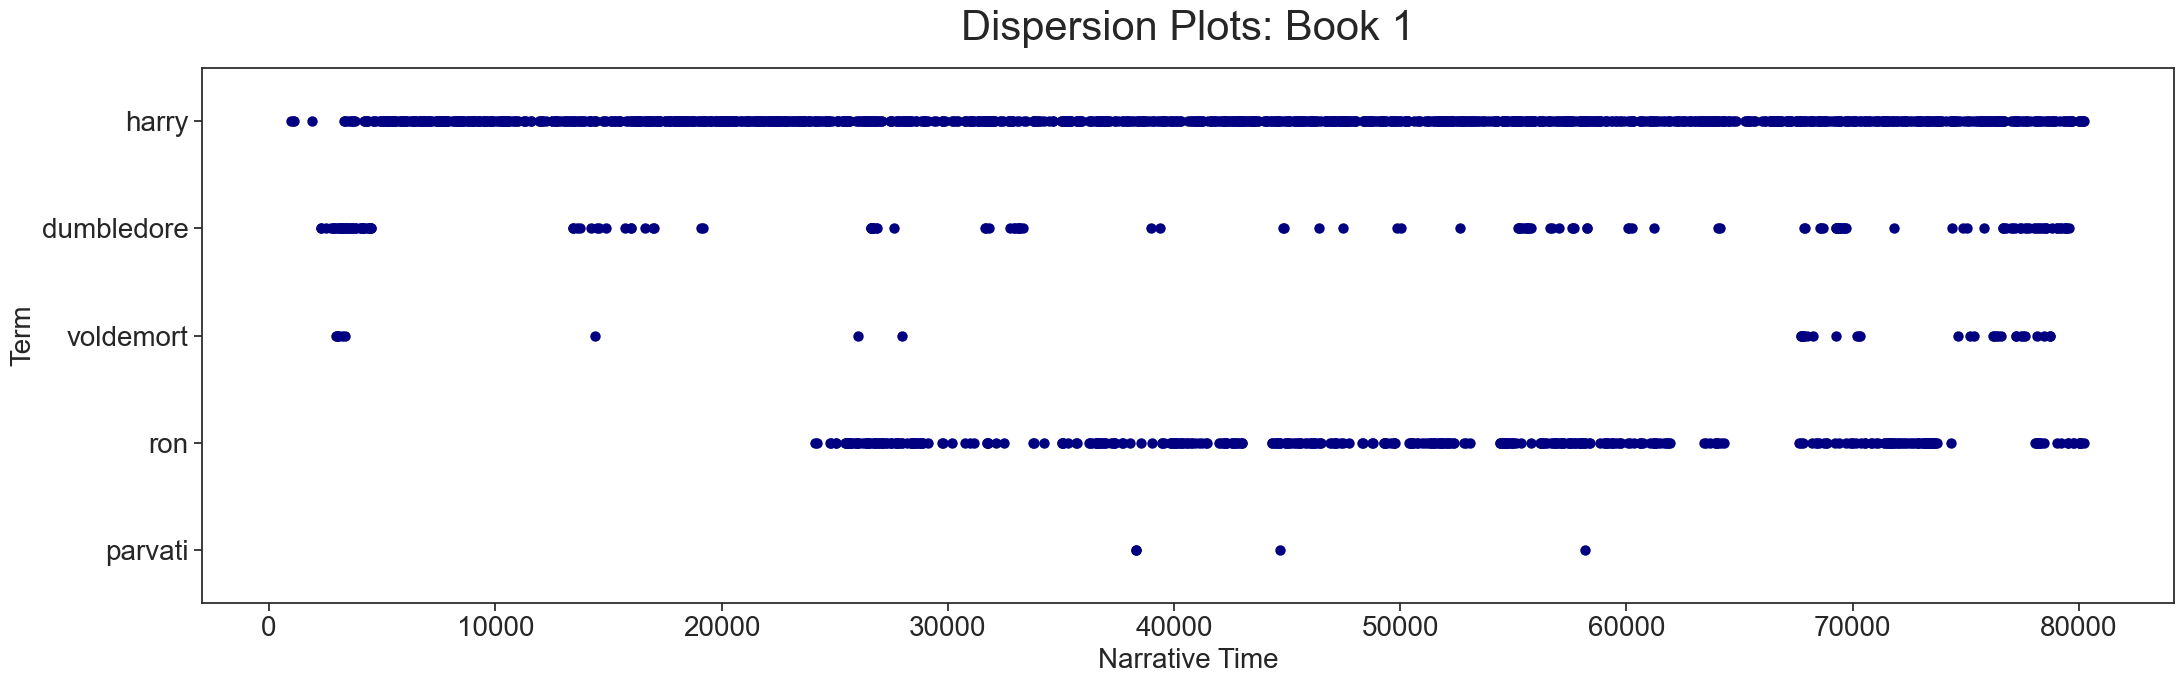

In [131]:
B = BOOK1['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
names = 'harry voldemort dumbledore parvati crookshanks mundungus ron'.split()
plot_words(names, B, 1)

## Book 2 graph

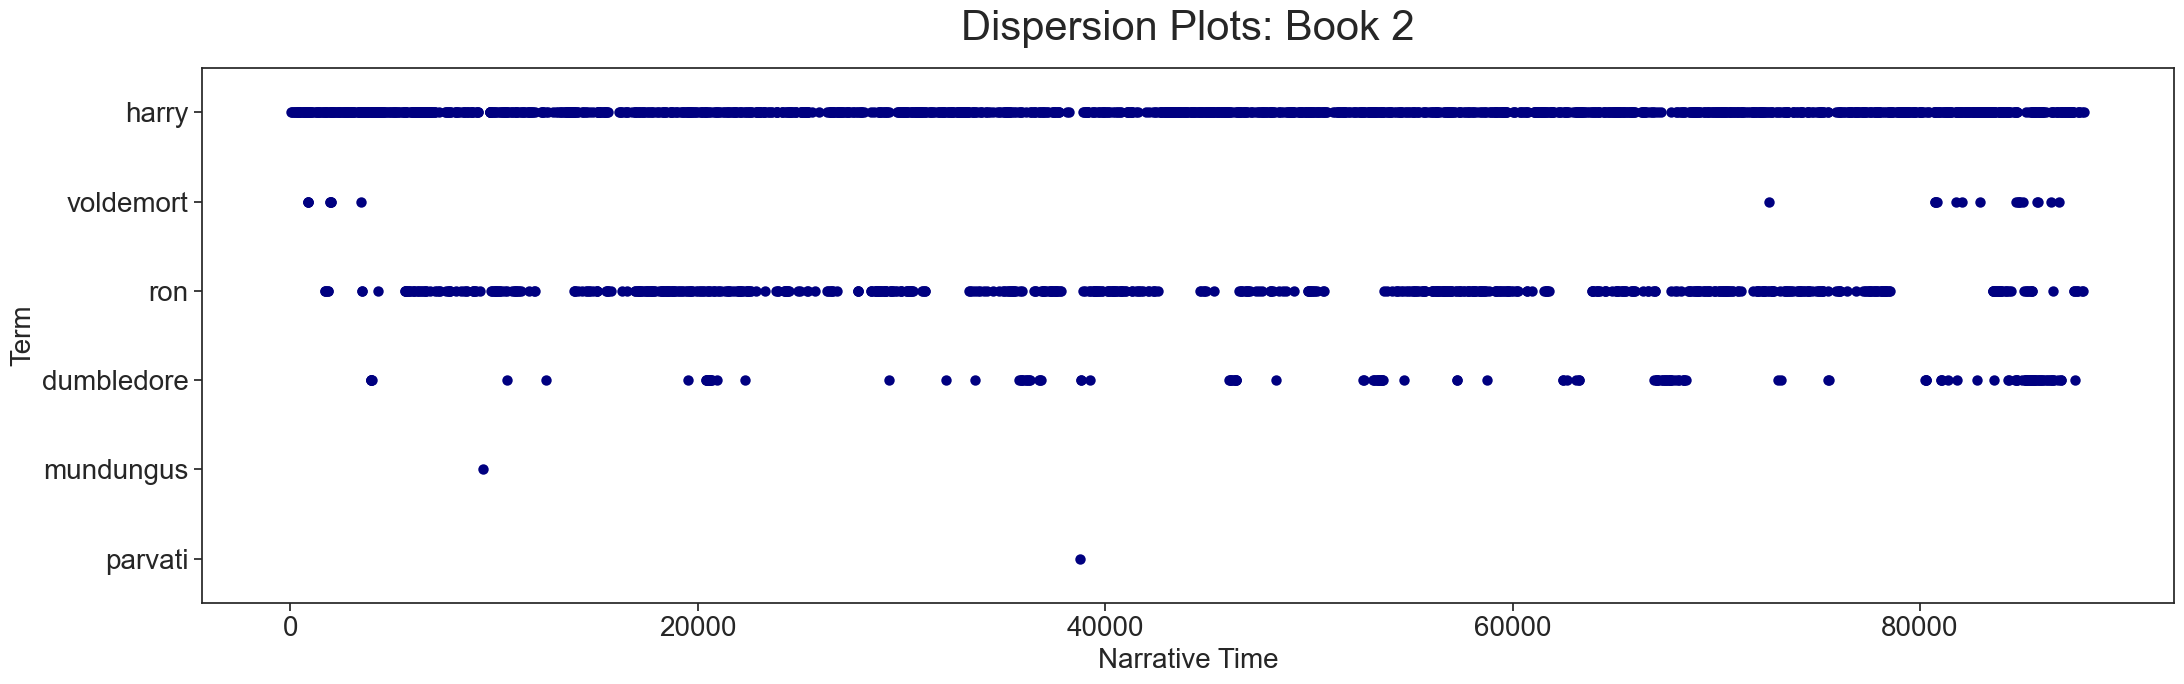

In [133]:
B = BOOK2['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
names = 'harry voldemort dumbledore parvati crookshanks mundungus ron'.split()
plot_words(names, B, 2)

## Book 3 graph

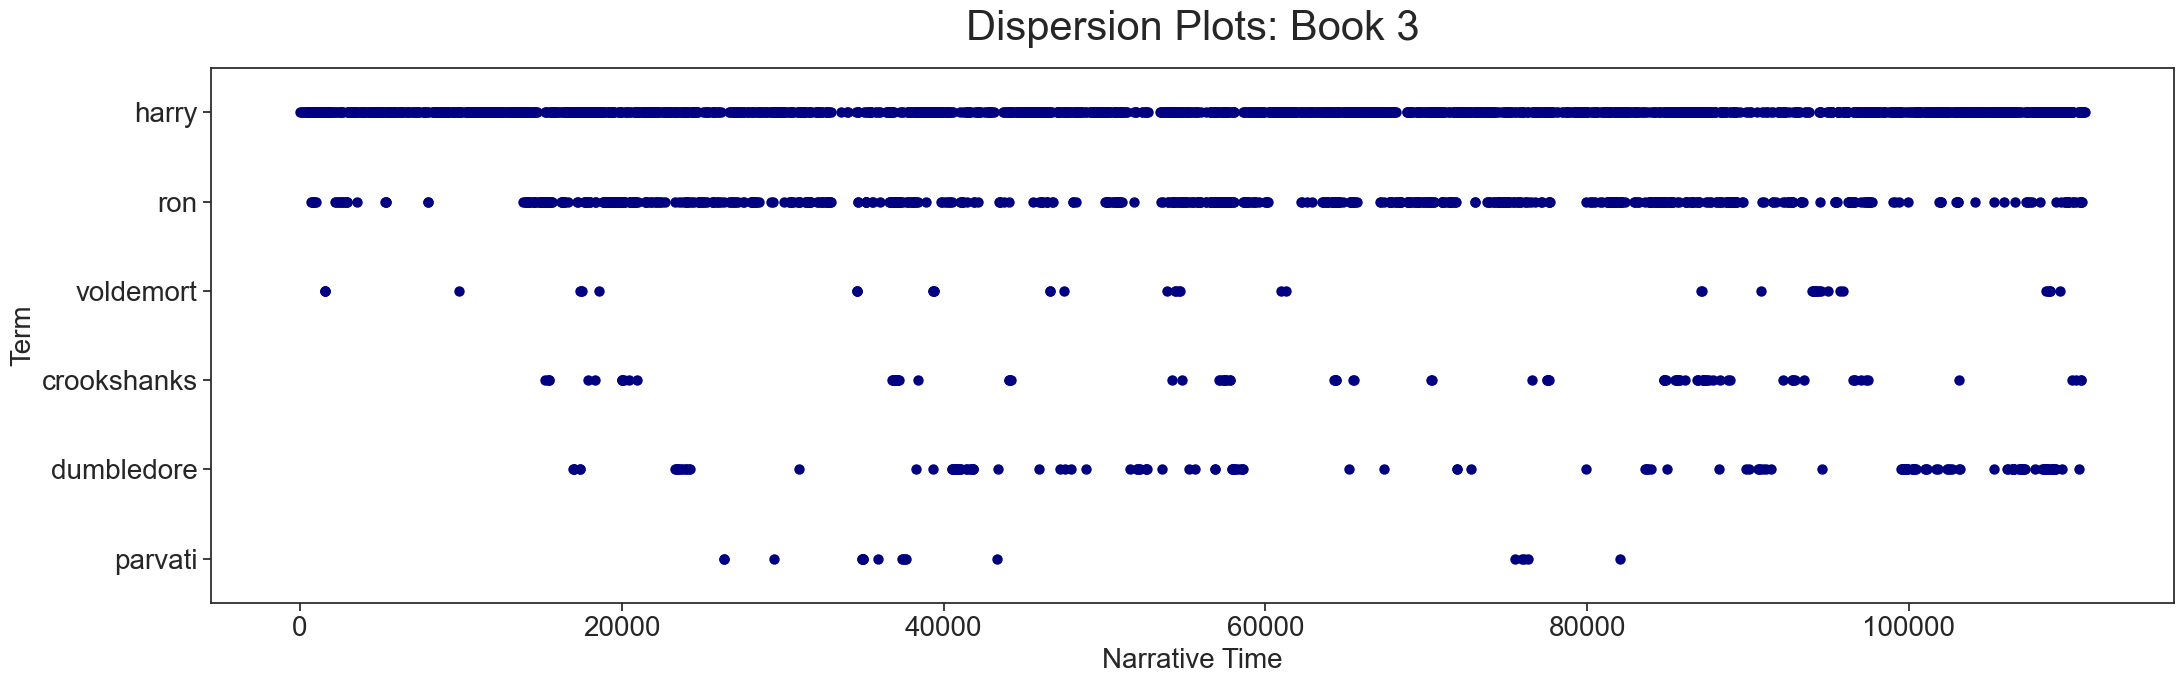

In [134]:
B = BOOK3['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
names = 'harry voldemort dumbledore parvati crookshanks mundungus ron'.split()
plot_words(names, B, 3)

## Book 4 graph

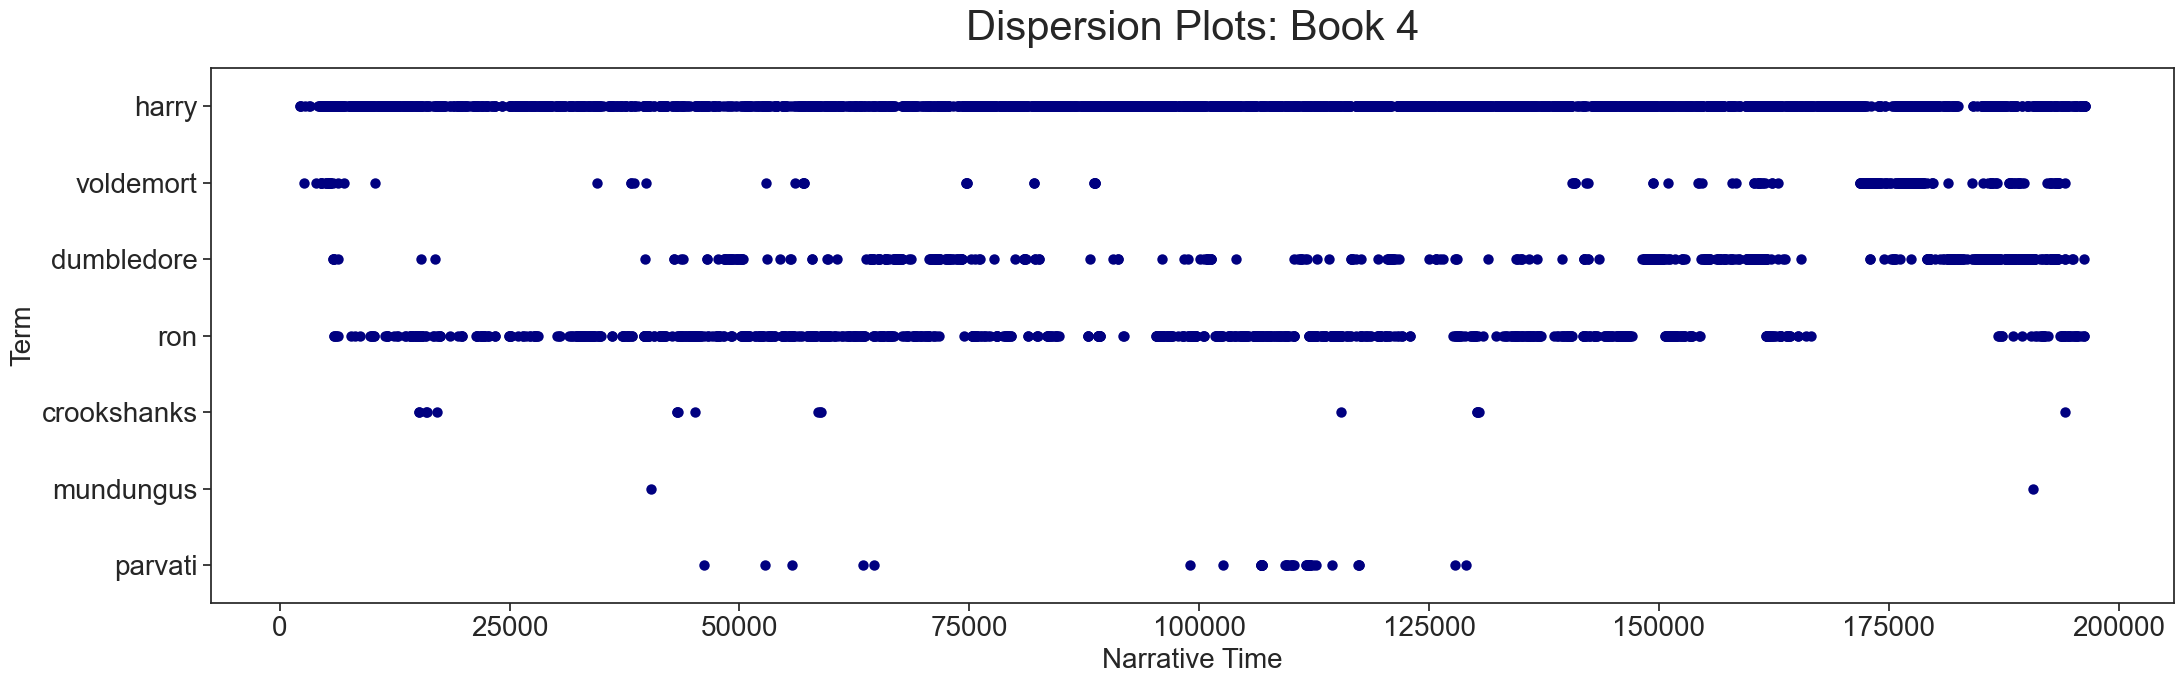

In [135]:
B = BOOK4['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
names = 'harry voldemort dumbledore parvati crookshanks mundungus ron'.split()
plot_words(names, B, 4)

## Book 5 graph

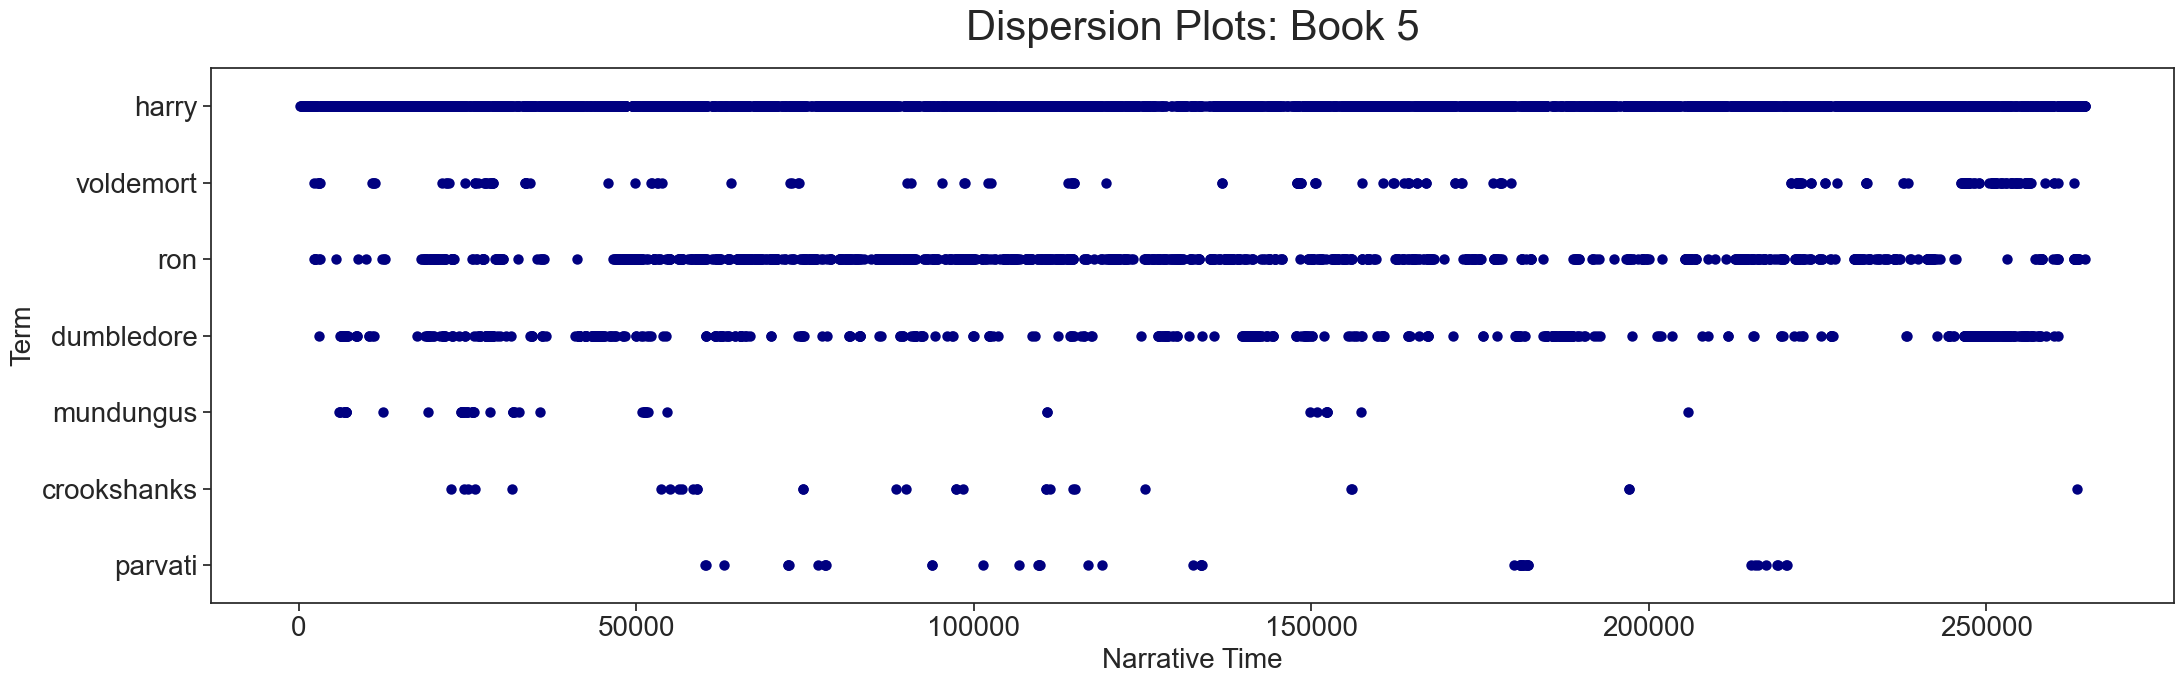

In [136]:
B = BOOK5['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
names = 'harry voldemort dumbledore parvati crookshanks mundungus ron'.split()
plot_words(names, B, 5)

## Book 6 graph

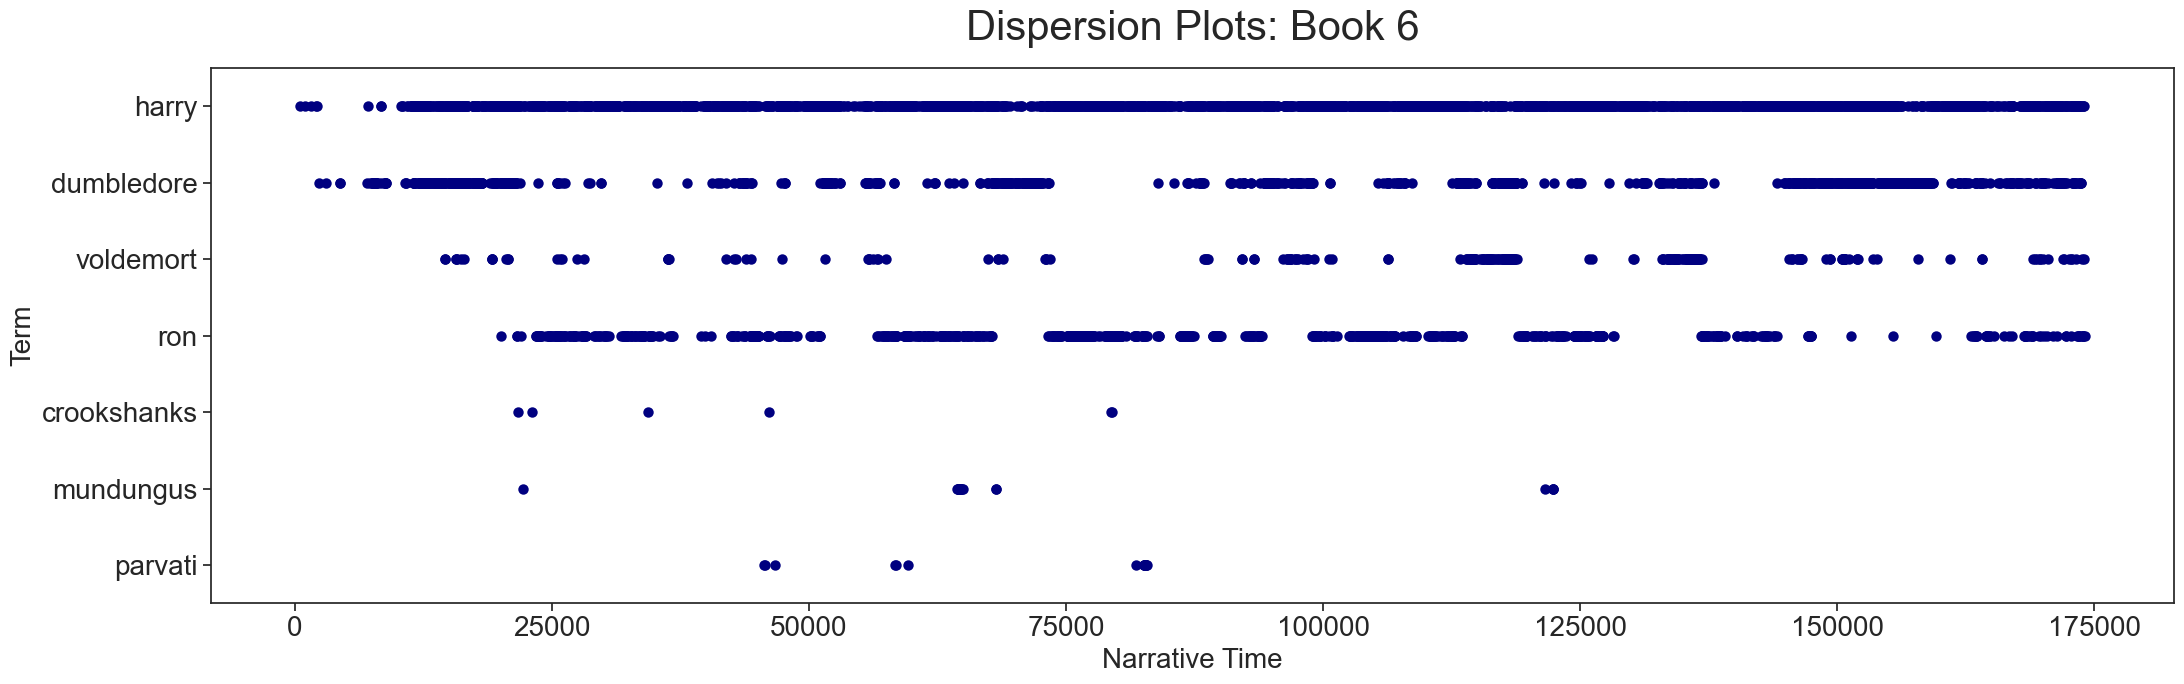

In [137]:
B = BOOK6['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
names = 'harry voldemort dumbledore parvati crookshanks mundungus ron'.split()
plot_words(names, B, 6)

## Book 7 graph

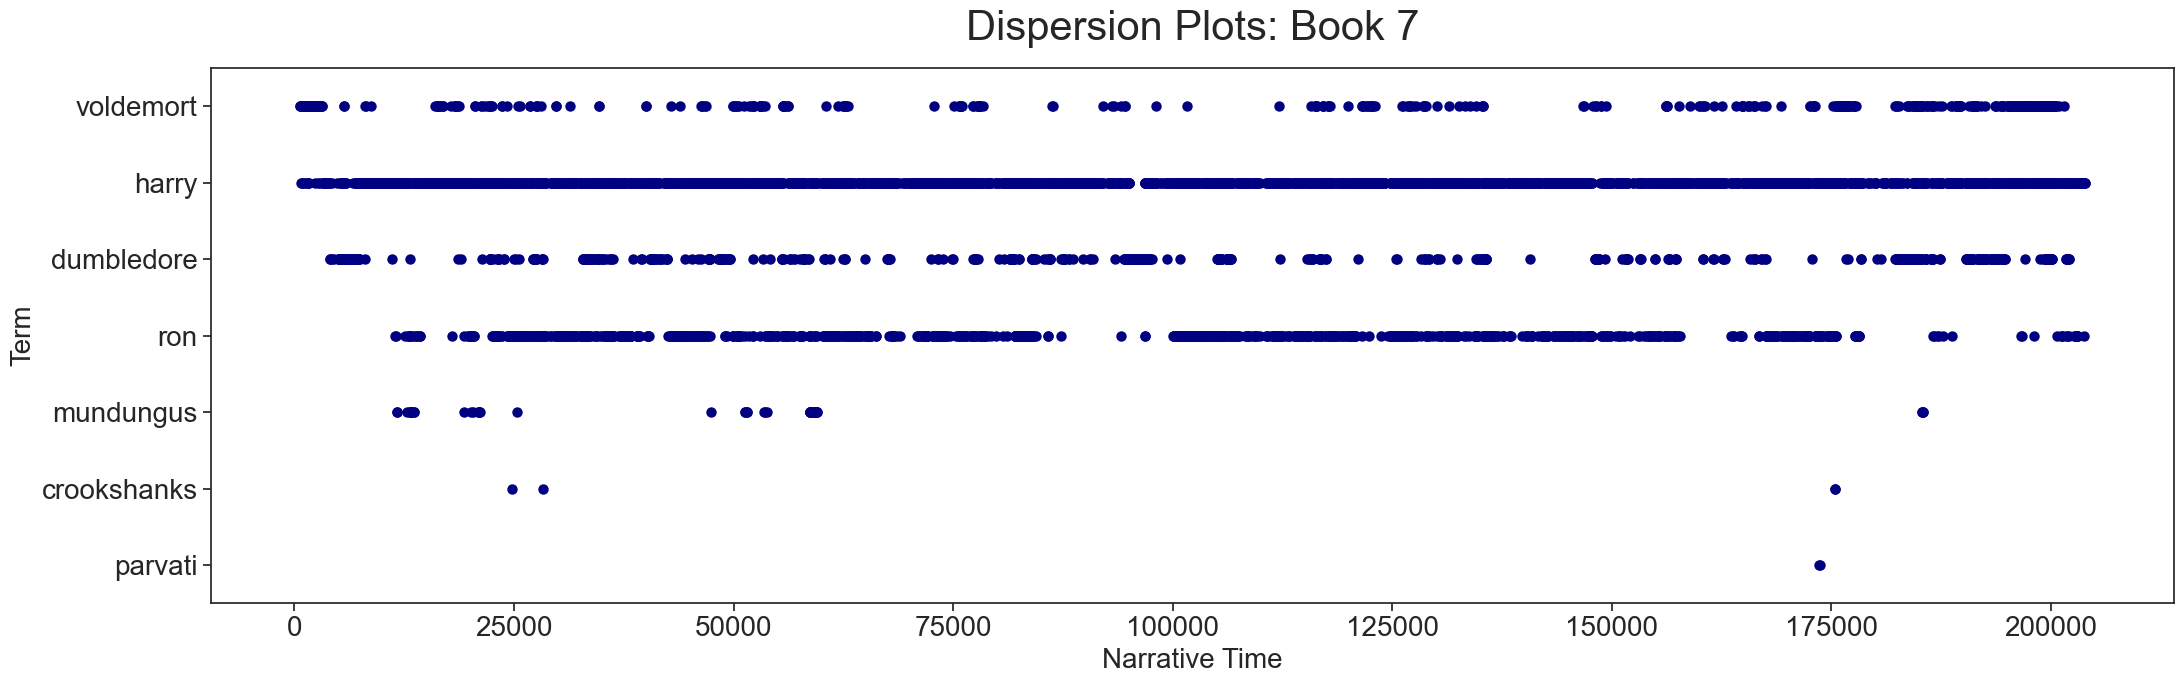

In [138]:
B = BOOK7['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
names = 'harry voldemort dumbledore parvati crookshanks mundungus ron'.split()
plot_words(names, B, 7)

## Significance Preprocessing

In [37]:
DOCS = BOW.groupby(bag).n.sum().to_frame('n')
DOCS['book_chap_sig'] = TFIDF.T.mean().to_frame('book_chap_sig')

# PCA

In [38]:
# Normalize vector lengths
TFIDF_L2 = (TFIDF[VIDX].T / norm(TFIDF[VIDX], 2, axis=1)).T

# Center terms 
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()

# Compute covariance matrix
COV = TFIDF_L2.T.dot(TFIDF_L2) / (TFIDF_L2.shape[0] - 1)

# Decompose matrix
eig_vals, eig_vecs = eigh(COV)

# Create eigenvector df
eig_vec_df = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)

# Create eigenvalues df
eig_val_df = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
eig_val_df.index.name = 'term_str'

# join the dfs
eig_pairs = eig_val_df.join(eig_vec_df.T)

In [39]:
COMPS = eig_pairs.sort_values('eig_val', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'

## Project Docs onto Components

In [40]:
# get Document Component Matrix
DCM = TFIDF_L2.dot(COMPS[COV.index].T)

# add metadata for display purposes
LIB_COLS = LIB.columns
DCM = DCM.join(LIB[LIB_COLS], on='book_id')

# define doc field to name each chapter
DCM['doc'] = DCM.apply(lambda x: f"{x.title} {str(x.name[1]).zfill(2)}", 1)

## Create `LOADINGS` Table

In [41]:
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'

# LDA

## Set Up

In [42]:
colors = "YlGnBu"

# count vectorizer
sns.set(style='ticks')
ngram_range = (1,2)
max_features = 4000
stop_words = 'english'

# Latent Dirichlet Allocation
n_topics = 20
n_components = 20
max_iter = 5
n_top_terms = 7
learning_offset = 50
random_state = 0
BAG = ['book_id', 'chap_num']

CORPUS_chaps = CORPUS[CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

## Create Vector Space and Generate Model

In [43]:
VOCAB_LDA, DOCS_LDA, TNAMES, THETA, PHI, TOPICS = hpe.create_lda_model(CORPUS_chaps, max_features, ngram_range, stop_words, n_components, max_iter, learning_offset, random_state, n_topics, n_top_terms)

TOPICS

term_str,0,1,2,3,4,5,6
topic_id,,,,,,,
T00,ter,yeh,soul,way,owl,em,wizard
T01,door,way,time,eyes,voice,room,face
T02,family,mother,house,room,brother,death,wand
T03,patronum,head,wand,eyes,ground,moment,light
T04,team,field,time,voice,room,eyes,minutes
T05,wand,door,eyes,room,face,prophecy,moment
T06,jumble,freezing,hour time,worms,resemblance,banshee,reports
T07,time,door,face,room,eyes,voice,way
T08,water,lake,task,time,head,feet,merpeople


## Explore Model

In [44]:
THETA_topics = THETA.groupby('book_id').mean()
THETA_topics

,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19
book_id,,,,,,,,,,,,,,,,,,,,
1,0.073081,0.140133,0.000079,0.000079,0.002051,0.000079,0.000079,0.263275,0.000079,0.183162,0.038946,0.000079,0.030744,0.003096,0.168252,0.004961,0.026314,0.001522,0.022276,0.041714
2,0.000073,0.146255,0.000073,0.000073,0.044409,0.000073,0.000073,0.308773,0.000073,0.023431,0.000073,0.000073,0.007304,0.088316,0.251058,0.003575,0.000073,0.021694,0.000073,0.104452
3,0.010431,0.089706,0.000077,0.044845,0.046915,0.000077,0.000077,0.160805,0.000077,0.062055,0.058491,0.000077,0.001473,0.000077,0.254500,0.000642,0.056272,0.062230,0.000408,0.150763
4,0.009609,0.012918,0.000075,0.000075,0.000075,0.016032,0.000075,0.254432,0.063913,0.011786,0.032903,0.000075,0.057878,0.033915,0.247796,0.001170,0.076524,0.000558,0.027058,0.153131
5,0.020422,0.016517,0.011952,0.000054,0.000054,0.043744,0.000054,0.215947,0.003264,0.031159,0.070173,0.000054,0.051432,0.032091,0.357309,0.020156,0.027871,0.000242,0.000054,0.097449
6,0.035907,0.006111,0.000067,0.000067,0.000067,0.044657,0.000067,0.265105,0.000852,0.030404,0.039528,0.000067,0.133618,0.000067,0.312750,0.001862,0.036041,0.034793,0.000067,0.057902
7,0.001376,0.059039,0.059438,0.000074,0.000074,0.004445,0.000074,0.143845,0.002457,0.000074,0.103119,0.000074,0.151285,0.027069,0.019601,0.000335,0.000074,0.003125,0.023370,0.401055


### Find Most Strongly Associated Topics by Book

#### Book 1

In [45]:
THETA_1 = THETA_topics.T[1].to_frame('p').sort_values(by='p', ascending=False)
THETA_1.join(TOPICS)

,p,0,1,2,3,4,5,6
T07,0.263275,time,door,face,room,eyes,voice,way
T09,0.183162,team,match,time,broom,crowd,field,goal
T14,0.168252,time,voice,eyes,face,door,room,people
T01,0.140133,door,way,time,eyes,voice,room,face
T00,0.073081,ter,yeh,soul,way,owl,em,wizard
T19,0.041714,wand,eyes,face,head,time,voice,hand
T10,0.038946,room,wand,voice,hand,face,time,door
T12,0.030744,eyes,voice,time,wand,door,face,room
T16,0.026314,time,table,face,students,people,eyes,head
T18,0.022276,sidecar,motorbike,hair,time,boy,wand,bike


# Word 2 Vec

## Setup

In [46]:
test2 = CORPUS.loc[(CORPUS['pos'].str.startswith(('VB', 'NN')))]

# gensim format for word2vec
BAG = OHCO[:3] # bag is sent here

CORPUS_w2v = test2\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
CORPUS_w2v = [doc for doc in CORPUS_w2v if len(doc) > 1] # Lose single word docs

w2v_params = dict(window = 2,
                          vector_size = 256,
                          min_count = 80)

w2v_model = word2vec.Word2Vec(CORPUS_w2v, **w2v_params) # by chaps

## tSNE

In [47]:
# get coords
rowling_coords = pd.DataFrame(
    dict(
        vector = [w2v_model.wv.get_vector(w) for w in w2v_model.wv.key_to_index], 
        term_str = w2v_model.wv.key_to_index.keys()
    )).set_index('term_str')

In [48]:
# model building - set new model params if you want
learning_rate = 200
perplexity = 20
n_comps = 2
init = 'random'
n_iter = 1000
rand_state = 42

tsne_engine = TSNE(perplexity=perplexity, n_components=n_comps, init=init, n_iter=n_iter, random_state=rand_state)




In [49]:
np.array(rowling_coords.vector.to_list())

array([[-0.1104782 , -0.10504311,  0.02054359, ..., -0.32228658,
        -0.29183868, -0.1209797 ],
       [ 0.06602185, -0.05494059, -0.06444045, ..., -0.23910342,
        -0.2550349 , -0.05000657],
       [-0.2797689 , -0.37543878,  0.16365023, ...,  0.362901  ,
         0.14293802,  0.41569477],
       ...,
       [ 0.04385981, -0.01217722,  0.04471302, ..., -0.11321024,
        -0.17446959, -0.01406173],
       [-0.11327308, -0.06141889,  0.03318466, ..., -0.09129065,
        -0.08072751, -0.09148087],
       [-0.10281325, -0.02470049, -0.01772728, ..., -0.23985124,
        -0.1381408 , -0.05667573]], dtype=float32)

In [50]:
# rowling_tsne_model = tsne_engine.fit_transform(np.array(rowling_coords.vector.to_list()))

In [51]:
# rowling_coords['x'] =rowling_tsne_model[:,0]
# rowling_coords['y'] = rowling_tsne_model[:,1]

# VOCAB_tsne = pd.merge(VOCAB, rowling_coords, left_index=True, right_index=True)

# # for visualization, drop stopwords
# VOCAB_tsne = VOCAB_tsne[VOCAB_tsne.stop == 0]

## Plot tSNE

In [52]:
# # plot rowling
# px.scatter(VOCAB_tsne.reset_index(), 'x', 'y', title = 'Rowling tSNE',
#            text='term_str',  
#            hover_name='term_str',          
#            height=1000).update_traces(
#                 mode='markers+text', 
#                 textfont=dict(color='black', size=14, family='Arial'),
#                 textposition='top center')

## Analogies and Similarity

In [53]:
hpe.complete_analogy('harry', 'light', 'ron', w2v_model, 5)

,term,sim
0,darkness,0.797871
1,lit,0.795198
2,walls,0.788689
3,windows,0.787445
4,filled,0.782136


In [54]:
pd.DataFrame(w2v_model.wv.most_similar('ron'), columns=['term', 'sim'])

,term,sim
0,hermione,0.867269
1,ginny,0.842414
2,lavender,0.774171
3,seamus,0.772168
4,hagrid,0.762313
5,luna,0.753165
6,neville,0.750307
7,cho,0.744804
8,ernie,0.734452
9,grinning,0.722363


In [55]:
hpe.get_most_similar('ron', w2v_model)

,term,sim
0,hermione,0.867269
1,ginny,0.842414
2,lavender,0.774171
3,seamus,0.772168
4,hagrid,0.762313
5,luna,0.753165
6,neville,0.750307
7,cho,0.744804
8,ernie,0.734452
9,grinning,0.722363


# Sentiment Analysis

## Get Sentiment Analysis Lexicon

In [56]:
SALEX = pd.read_csv('data/salex_nrc.csv').set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX['polarity'] = SALEX.positive - SALEX.negative
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1) 

## Make `DTCM`

In [57]:
DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
TF = (DTCM.T / DTCM.T.max()).T

BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()

## Add Emotions

In [58]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [59]:
for col in emo_cols:
    B[col] = B[col] * B.tfidf

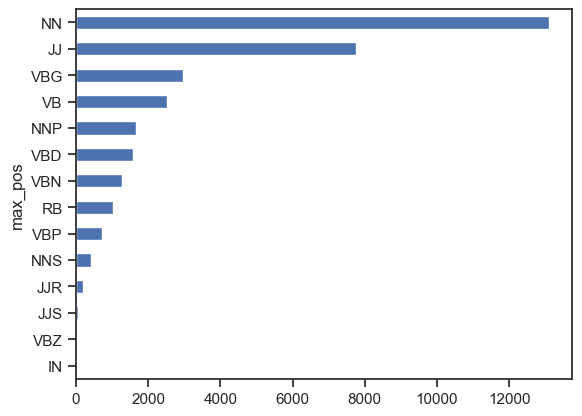

In [60]:
# emotion word counts by POS
B.max_pos.value_counts().sort_values().plot.barh();

## Display Emotions

In [61]:
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_CHAPS = B.groupby(['book_id','chap_num'])[emo_cols].mean()

EMO_BOOKS.index = LIB.title #book_title

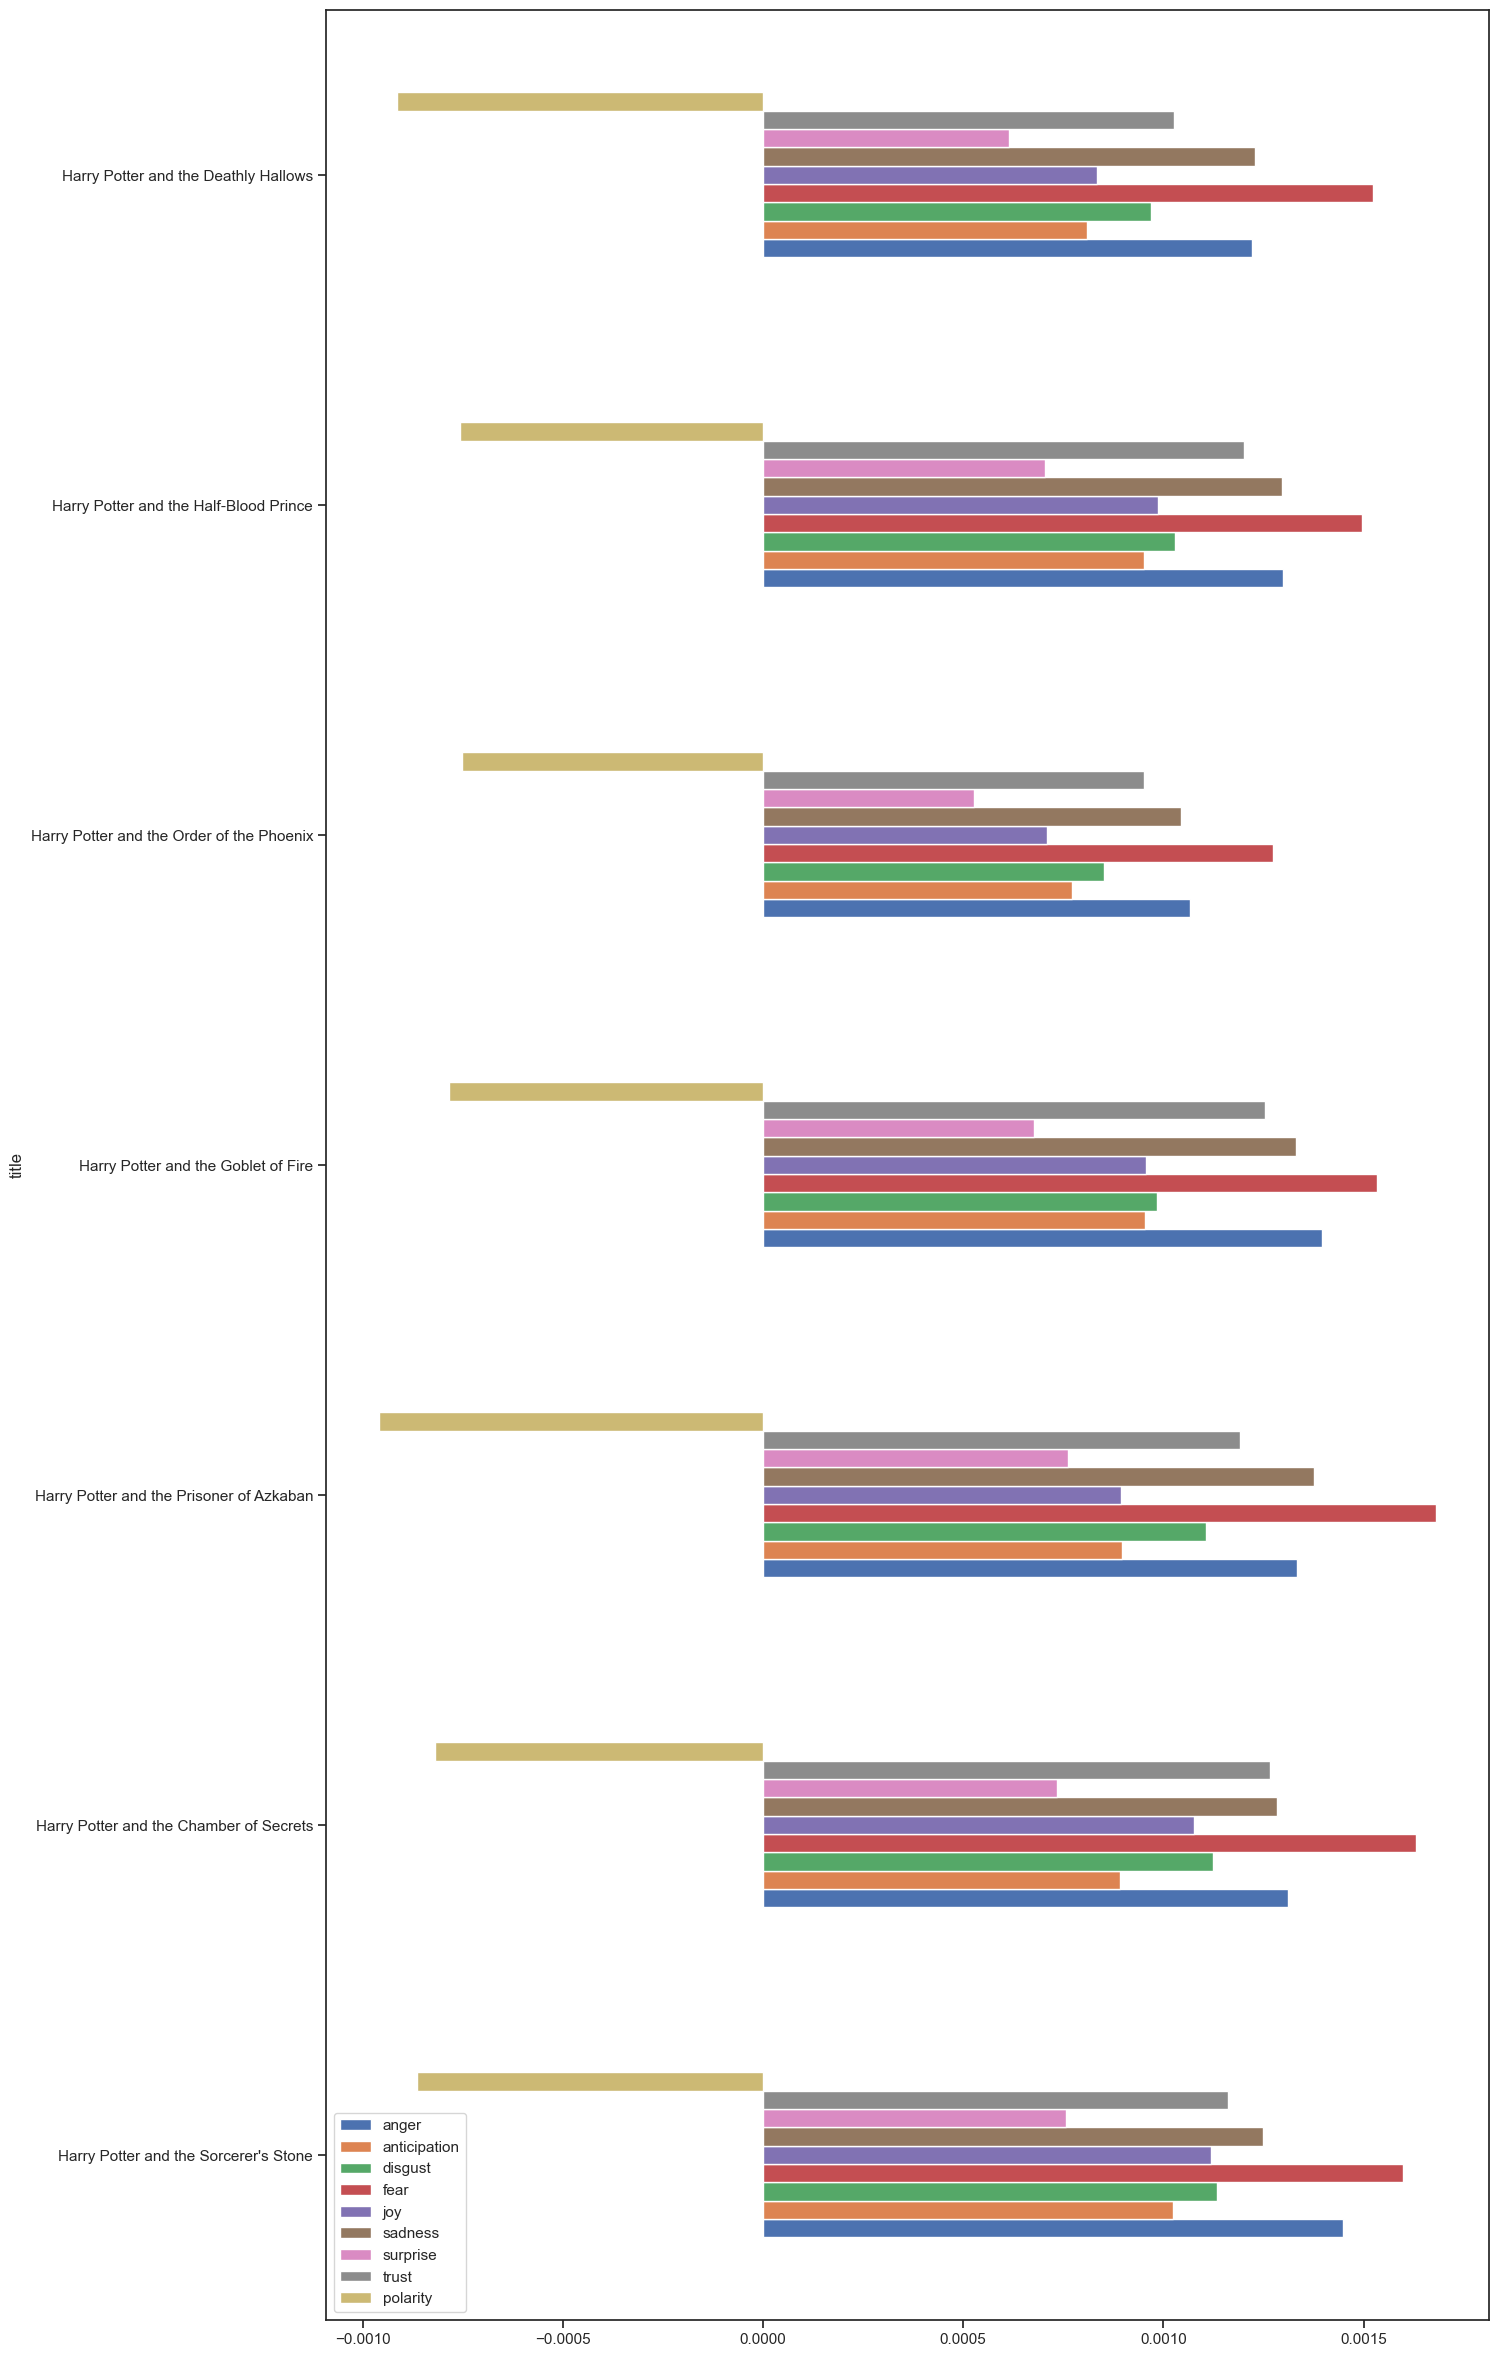

In [62]:
EMO_BOOKS.plot.barh(figsize=(15,30));

## Going In Depth With Book 1

In [ ]:
#DOC, TOKEN, TERM csvs, 

In [63]:
book1_chaps = EMO_CHAPS.loc[1] 

### Sentiment by Chapter

In [64]:
%pip install Jinja2==3.0.0


Note: you may need to restart the kernel to use updated packages.


In [65]:
book1_chaps.style.background_gradient(cmap='YlGnBu', axis=None)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity
chap_num,,,,,,,,,
1.000000,0.001028,0.001422,0.000936,0.001474,0.001735,0.000938,0.000993,0.001475,0.000328
2.000000,0.001218,0.001367,0.001626,0.001777,0.001592,0.001257,0.001145,0.001910,-0.000257
3.000000,0.001279,0.000699,0.001207,0.001059,0.000477,0.000925,0.000255,0.001287,-0.001230
4.000000,0.002318,0.001325,0.001850,0.002692,0.001282,0.002371,0.001123,0.001158,-0.002923
5.000000,0.001017,0.001028,0.001204,0.001226,0.000967,0.000906,0.000727,0.001193,-0.000577
6.000000,0.000990,0.000866,0.001080,0.001048,0.000946,0.001067,0.000610,0.000892,-0.000807
7.000000,0.000541,0.000822,0.000727,0.000881,0.001424,0.001009,0.000750,0.001330,0.000693
8.000000,0.001680,0.001553,0.001661,0.001886,0.001335,0.000927,0.001161,0.001535,-0.001051
9.000000,0.001255,0.001198,0.000909,0.001374,0.001160,0.001042,0.000990,0.001224,-0.000534


### Plot Sentiments

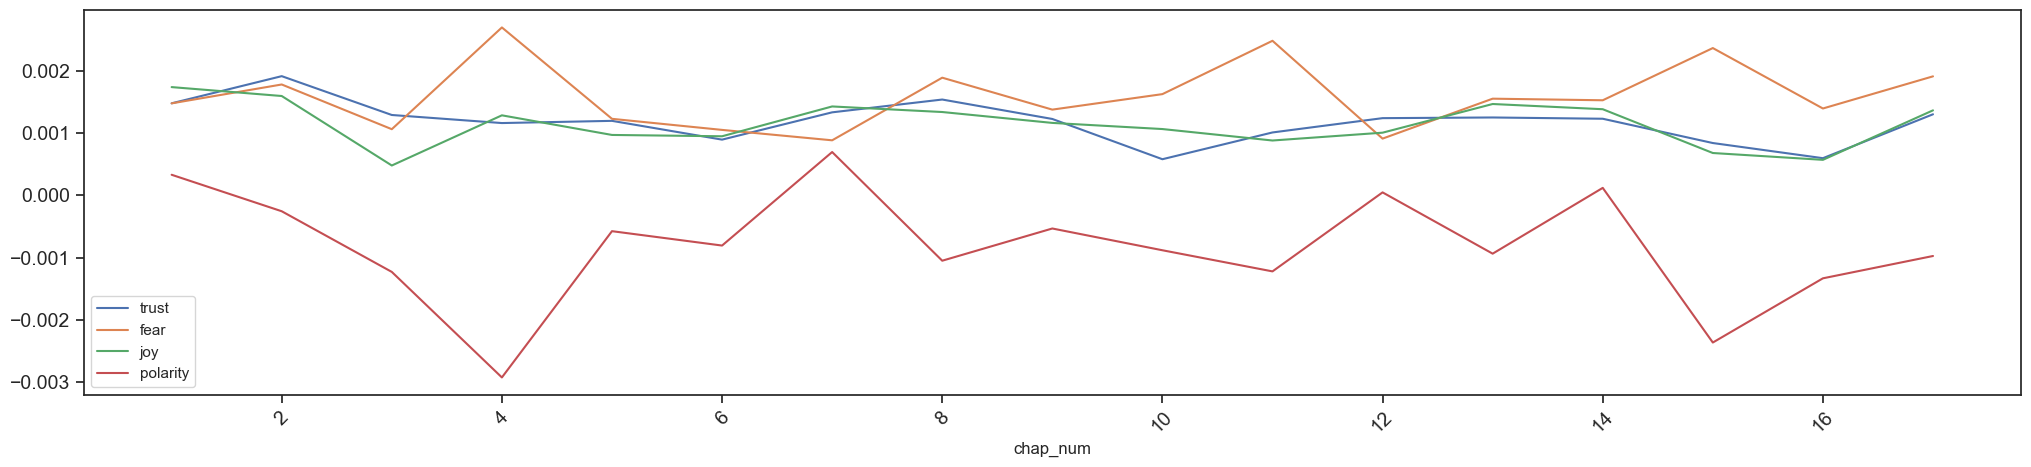

In [66]:
hpe.plot_sentiments(book1_chaps, ['trust','fear','joy','polarity'])

### Trying VADER

In [67]:
T = CORPUS.join(V, on='term_str').fillna(0)

book1 = T.loc[1].copy()

emo = 'polarity'
book1['html'] = book1.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.term_str), 1)

SENTS = OHCO[:4]
book1_sents = book1.groupby(SENTS[1:])[emo_cols].mean()

book1_sents['sent_str'] = book1.groupby(SENTS[1:]).term_str.apply(lambda x: x.str.cat(sep=' '))

book1_sents['html_str'] = book1.groupby(SENTS[1:]).html.apply(lambda x: x.str.cat(sep=' '))

analyser = SentimentIntensityAnalyzer()

book1_vader_cols = book1_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
book1_vader = pd.concat([book1_sents, book1_vader_cols], axis=1)

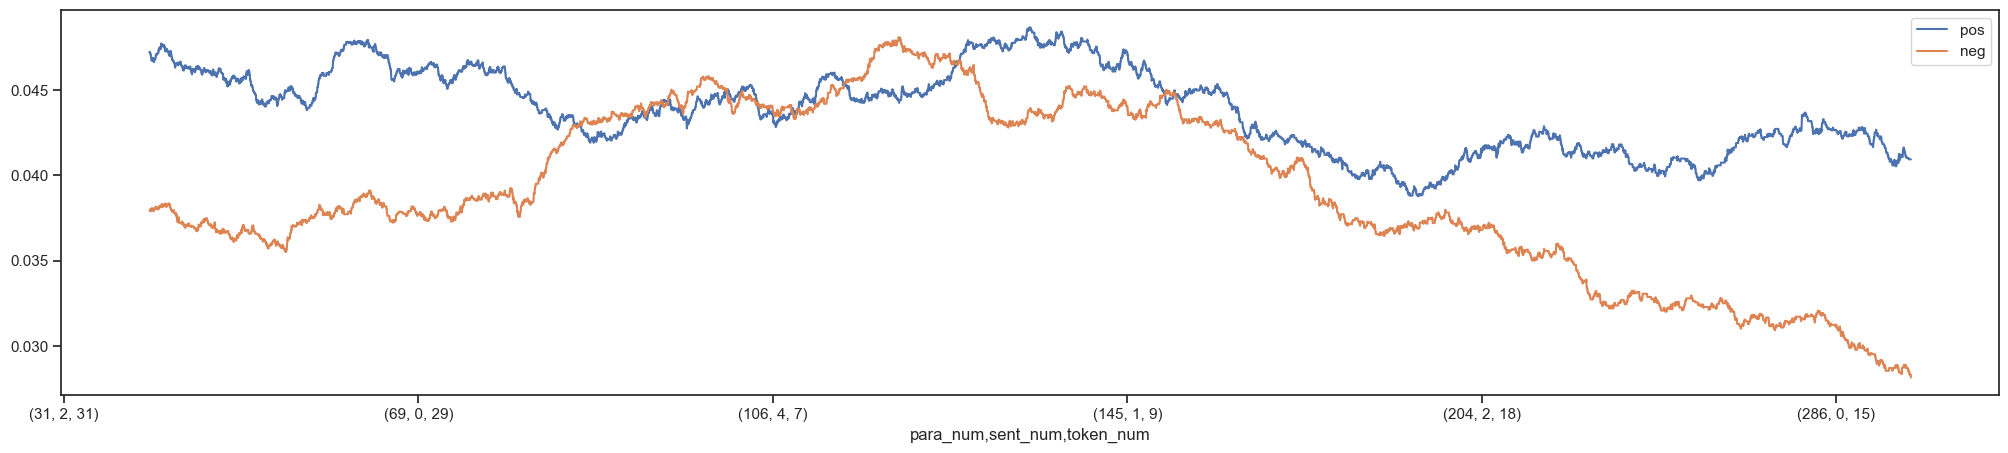

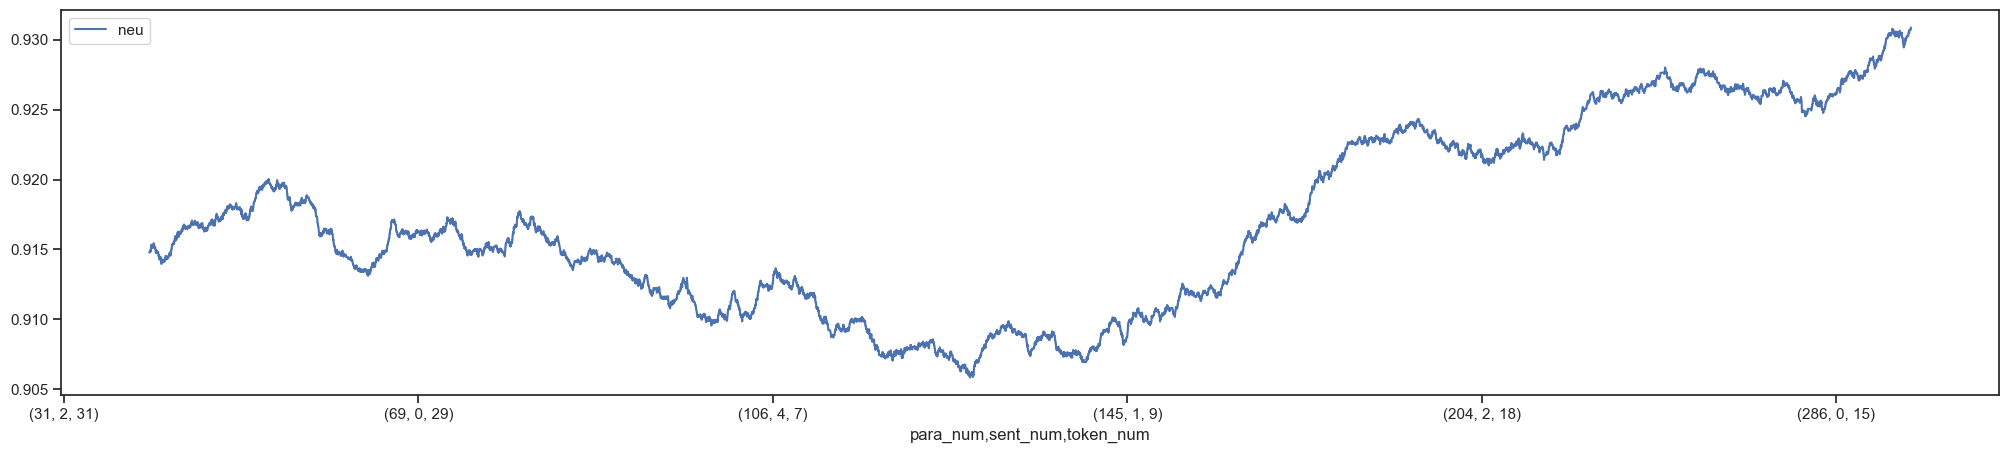

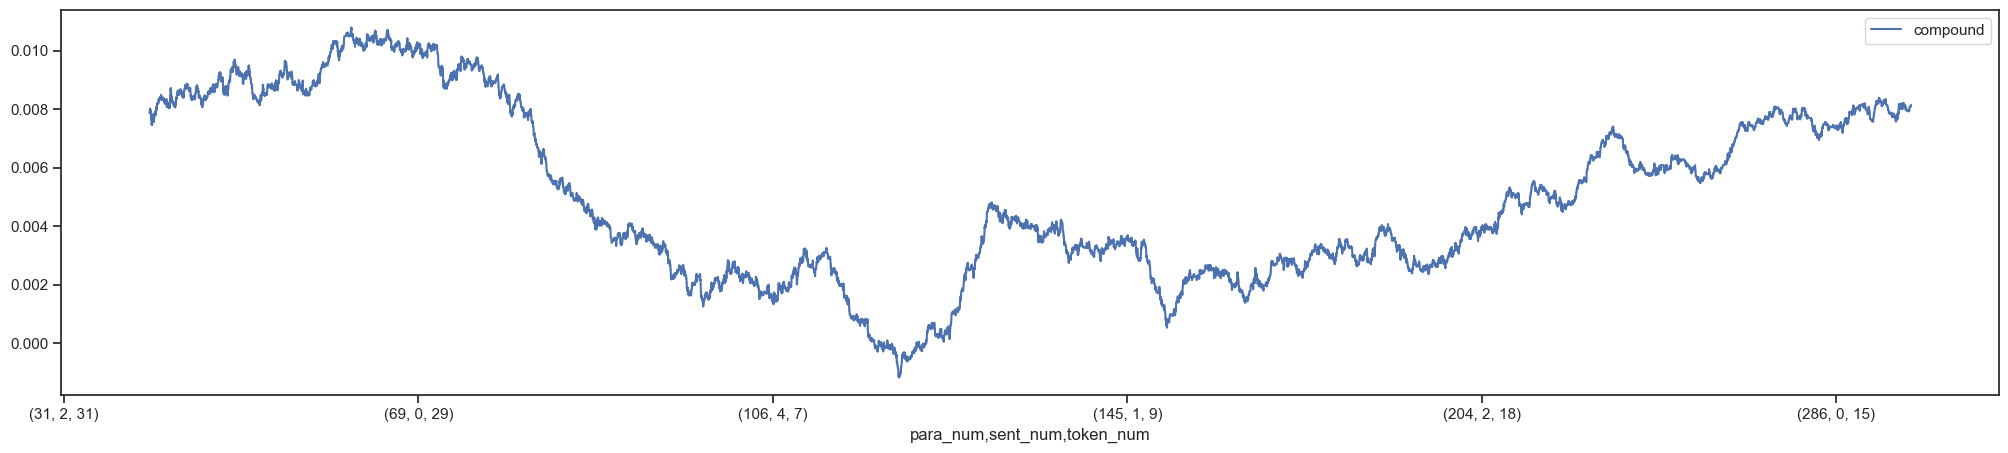

In [68]:
w = int(book1_vader.shape[0] / 5)
book1_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5));
book1_vader[['neu']].rolling(w).mean().plot(figsize=(25,5));
book1_vader[['compound']].rolling(w).mean().plot(figsize=(25,5));

# Hierarchical Plots with Emo Space

In [69]:
from hac2 import HAC

In [70]:
EMOX = B[emo_cols].groupby('book_id').mean()\
    .join(LIB.title).reset_index(drop=True).set_index('title')



In [71]:
EMOX

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity
title,,,,,,,,,
Harry Potter and the Sorcerer's Stone,0.001449,0.001024,0.001133,0.001598,0.001118,0.001248,0.000757,0.001162,-0.000864
Harry Potter and the Chamber of Secrets,0.001311,0.000891,0.001125,0.001631,0.001077,0.001285,0.000735,0.001265,-0.000819
Harry Potter and the Prisoner of Azkaban,0.001333,0.000898,0.001106,0.001681,0.000894,0.001376,0.000762,0.001192,-0.000959
Harry Potter and the Goblet of Fire,0.001395,0.000954,0.000985,0.001535,0.000956,0.001330,0.000677,0.001253,-0.000785
Harry Potter and the Order of the Phoenix,0.001065,0.000772,0.000852,0.001274,0.000710,0.001043,0.000527,0.000952,-0.000751
Harry Potter and the Half-Blood Prince,0.001298,0.000952,0.001029,0.001496,0.000986,0.001296,0.000705,0.001202,-0.000756
Harry Potter and the Deathly Hallows,0.001221,0.000810,0.000969,0.001523,0.000834,0.001229,0.000614,0.001025,-0.000913


<Figure size 640x480 with 0 Axes>

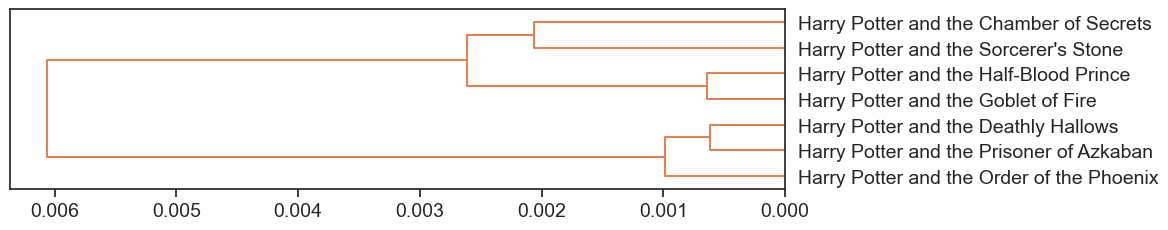

In [72]:
emo_tree = HAC(EMOX)
emo_tree.color_thresh=.03
emo_tree.plot()

# Semantic Search

In [73]:
BAG = NEW_OHCO[:3]

CORPUS_by_para = CORPUS.groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})\
    .reset_index()

CORPUS_text = CORPUS_by_para.para_str

In [74]:
# embeddings take 5 minutes to generate, so just loading - created by Nick Kalenichenko
corpus_embeddings = torch.load("data/harrypotter.pt")

In [75]:
hpe.search_potter("anything s possible if you've got enough nerve", 8, corpus_embeddings, CORPUS_by_para, [5, 6, 7])

[{'Book Number: 5, Chapter Number: 29': 'thinking anything s possible if you '
                                        've got enough nerve'},
 {'Book Number: 5, Chapter Number: 21': 'he could not think a tingling '
                                        'sensation was spreading throughout '
                                        'him paralyzing his arms legs and '
                                        'brain'},
 {'Book Number: 7, Chapter Number: 15': 'an electric current seemed to course '
                                        'through harry jangling his every '
                                        'nerve as he stood rooted to the spot'},
 {'Book Number: 6, Chapter Number: 27': 'oh weaker resistance slower reflexes '
                                        'amycus said dumbledore old age in '
                                        'short one day perhaps it will happen '
                                        'to you if you are lucky'},
 {'Book Number: 6, Chapter Number: 26'

# Export Files

All files below are what is required for the final project, exported to my output directory.

## Basic

In [145]:
# annotated with statistical and linguistic features, such as DFIDF
VOCAB.to_csv('tables/VOCAB.csv', index=True)

In [144]:
# this is a tokens table annotated with pos, term_str, and token_str. It should include and index that represents the OHCO of the documents in your corpus
CORPUS.to_csv('tables/CORPUS.csv', index=True)


In [143]:
# metadata for the source files
LIB.to_csv('tables/LIB.csv', index=True)

## PCA

In [152]:
# table of documents and components
DCM.to_csv('tables/DCM_pca.csv', index=True)

In [153]:
# table of components and word counts (i.e., the “loadings”), either added to the VOCAB table or as a separate table with a shared index with the VOCAB table
LOADINGS.to_csv('tables/LOADINGS_pca.csv', index=True)

## LDA

In [151]:
# document and topic concentrations
THETA_topics.to_csv('tables/THETA_lda.csv', index=True)

In [155]:
# topics and term counts, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table
PHI.T.to_csv('tables/PHI_lda.csv', index=True)

## Word2Vec

In [83]:
# terms and embeddings, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table
VOCAB_tsne.to_csv('output/VOCAB_w2v.csv', index=True)

## Sentiment Analysis

In [159]:
# sentiment and emotion values as features in VOCAB or as a separate table with a shared index with the VOCAB table
V.to_csv('tables/VOCAB_sentiment.csv', index=True)

In [161]:
# sentiment polarity and emotions for each document
EMO_BOOKS.to_csv('tables/BOOK_sentiment.csv', index=True)